# GrowMate: FLAN-T5 Hydroponic Chatbot

This notebook creates an advanced hydroponic chatbot using Google's FLAN-T5-base model. FLAN-T5 is fine-tuned for instruction following, making it ideal for conversational AI applications.

## Features:
- **FLAN-T5-base**: More powerful than T5-small with better instruction following
- **Hydroponic Domain**: Specialized for hydroponic farming questions
- **Conversational**: Natural dialogue capabilities
- **Rwanda Context**: Tailored for local farming conditions

## Workflow:
1. **Setup & Data Loading** - Load hydroponic FAQ data
2. **FLAN-T5 Model Setup** - Configure the instruction-tuned model
3. **Data Preprocessing** - Format data for instruction tuning
4. **Fine-tuning** - Train on hydroponic domain
5. **Evaluation & Testing** - Validate performance
6. **Deployment Prep** - Save model for production

In [1]:
# Install Required Packages
import subprocess
import sys
from typing import List

def install_package(package: str) -> None:
    """Install a package using pip."""
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package], 
                            stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        print(f"✓ {package}")
    except subprocess.CalledProcessError:
        print(f"✗ Failed to install {package}")

# Required packages with specific versions for compatibility
REQUIRED_PACKAGES: List[str] = [
    "transformers>=4.25.0",
    "torch",
    "datasets",
    "accelerate",
    "rouge-score", 
    "evaluate",
    "pandas",
    "numpy",
    "scikit-learn",
    "nltk",
    "matplotlib",
    "seaborn"
]

print("Installing required packages...")
for package in REQUIRED_PACKAGES:
    install_package(package)

print("\nPackage installation completed!")

Installing required packages...
✓ transformers>=4.25.0
✓ torch
✓ datasets
✓ accelerate
✓ rouge-score
✓ evaluate
✓ pandas
✓ numpy
✓ scikit-learn
✓ nltk
✓ matplotlib
✓ seaborn

Package installation completed!


In [ ]:
# Import Required Libraries
import re
import warnings
from pathlib import Path
from typing import Dict, List, Tuple, Optional

import torch
import pandas as pd
import numpy as np
import evaluate
from tqdm.auto import tqdm

# Matplotlib configuration for Jupyter
import matplotlib.pyplot as plt
import seaborn as sns
# Enable inline plotting for Jupyter
try:
    get_ipython().run_line_magic('matplotlib', 'inline')
except:
    pass  # Not in Jupyter environment

from sklearn.model_selection import train_test_split
from transformers import (
    T5Tokenizer, 
    T5ForConditionalGeneration,
    TrainingArguments,
    Trainer,
    DataCollatorForSeq2Seq
)
from datasets import Dataset

# Configure warnings and display
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Configure plotting style for better display
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['figure.dpi'] = 100  # Good quality for notebook display
plt.rcParams['savefig.dpi'] = 150  # Higher quality if saved
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
print(f"PyTorch: {torch.__version__}")

# Directory setup
BASE_DIR = Path.cwd().parent
DATA_DIR = BASE_DIR / 'data'
MODEL_DIR = BASE_DIR / 'trained_model'
MODEL_DIR.mkdir(exist_ok=True)

print(f"\nDirectories:")
print(f"   Base: {BASE_DIR}")
print(f"   Data: {DATA_DIR}")
print(f"   Model: {MODEL_DIR}")

c:\Users\HP\Desktop\ALU\Farmsmart_growmate_chatbot\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu
PyTorch: 2.8.0+cpu

Directories:
   Base: c:\Users\HP\Desktop\ALU\Farmsmart_growmate_chatbot
   Data: c:\Users\HP\Desktop\ALU\Farmsmart_growmate_chatbot\data
   Model: c:\Users\HP\Desktop\ALU\Farmsmart_growmate_chatbot\trained_model


## 2. Load and Explore Hydroponic Data

In [3]:
# Load and Explore Hydroponic Data
def load_hydroponic_data(data_path: Path) -> pd.DataFrame:
    """Load and validate hydroponic FAQ data."""
    if not data_path.exists():
        raise FileNotFoundError(f"Data file not found: {data_path}")
    
    df = pd.read_csv(data_path)
    
    # Validate required columns
    required_columns = ['question', 'answer']
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"Missing required columns: {missing_columns}")
    
    return df

# Load the data
data_file = DATA_DIR / 'hydroponic_FAQS.csv'
df = load_hydroponic_data(data_file)

print(f"Dataset Overview:")
print(f"   Samples: {len(df):,}")
print(f"   Columns: {list(df.columns)}")

# Data quality assessment
valid_questions = df['question'].notna().sum()
valid_answers = df['answer'].notna().sum()
missing_values = df.isnull().sum().sum()

print(f"\nData Quality:")
print(f"   Valid questions: {valid_questions:,} ({valid_questions/len(df)*100:.1f}%)")
print(f"   Valid answers: {valid_answers:,} ({valid_answers/len(df)*100:.1f}%)")
print(f"   Missing values: {missing_values:,}")

print(f"\nSample Data:")
display(df.head(3))

Dataset Overview:
   Samples: 625
   Columns: ['question', 'answer']

Data Quality:
   Valid questions: 625 (100.0%)
   Valid answers: 625 (100.0%)
   Missing values: 0

Sample Data:


,question,answer
0,What beginner mistakes should I avoid?,Overfeeding low dissolved oxygen poor sanitati...
1,How do I keep records effectively?,Use a daily log for pH; EC; water temp; air te...
2,How often should I calibrate meters?,Calibrate pH monthly and EC/TDS quarterly or a...


## 3. Load FLAN-T5-base Model


Data Analysis and Visualization:


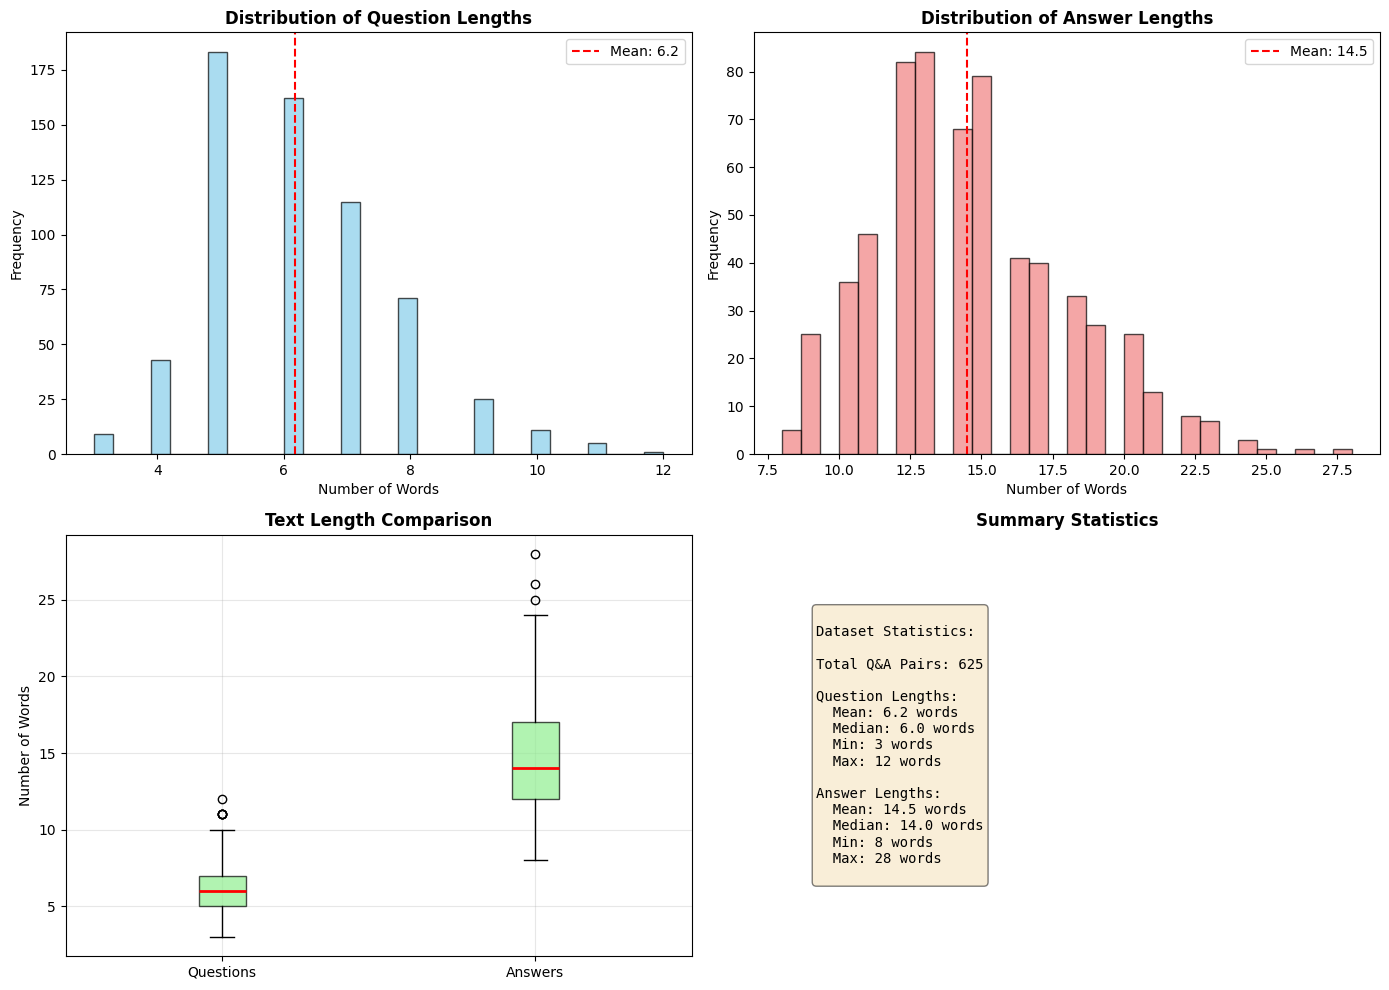


Visualization saved to: c:\Users\HP\Desktop\ALU\Farmsmart_growmate_chatbot\trained_model\data_visualization.png


In [ ]:
# DATA VISUALIZATION
print("\nData Analysis and Visualization:")
print("="*60)

# Calculate text lengths
df['question_length'] = df['question'].str.split().str.len()
df['answer_length'] = df['answer'].str.split().str.len()

# Create visualizations with larger size
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribution of question lengths
axes[0, 0].hist(df['question_length'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Question Lengths', fontsize=14, fontweight='bold', pad=10)
axes[0, 0].set_xlabel('Number of Words', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].axvline(df['question_length'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["question_length"].mean():.1f}')
axes[0, 0].legend(fontsize=11)
axes[0, 0].tick_params(labelsize=10)

# 2. Distribution of answer lengths
axes[0, 1].hist(df['answer_length'], bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution of Answer Lengths', fontsize=14, fontweight='bold', pad=10)
axes[0, 1].set_xlabel('Number of Words', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].axvline(df['answer_length'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["answer_length"].mean():.1f}')
axes[0, 1].legend(fontsize=11)
axes[0, 1].tick_params(labelsize=10)

# 3. Box plot for question and answer lengths
data_to_plot = [df['question_length'], df['answer_length']]
axes[1, 0].boxplot(data_to_plot, labels=['Questions', 'Answers'], patch_artist=True,
                    boxprops=dict(facecolor='lightgreen', alpha=0.7),
                    medianprops=dict(color='red', linewidth=3))
axes[1, 0].set_title('Text Length Comparison', fontsize=14, fontweight='bold', pad=10)
axes[1, 0].set_ylabel('Number of Words', fontsize=12)
axes[1, 0].tick_params(labelsize=11)
axes[1, 0].grid(True, alpha=0.3)

# 4. Dataset statistics summary
stats_text = f"""
Dataset Statistics:

Total Q&A Pairs: {len(df)}

Question Lengths:
  Mean: {df['question_length'].mean():.1f} words
  Median: {df['question_length'].median():.1f} words
  Min: {df['question_length'].min()} words
  Max: {df['question_length'].max()} words

Answer Lengths:
  Mean: {df['answer_length'].mean():.1f} words
  Median: {df['answer_length'].median():.1f} words
  Min: {df['answer_length'].min()} words
  Max: {df['answer_length'].max()} words
"""
axes[1, 1].text(0.1, 0.5, stats_text, fontsize=11, family='monospace',
                verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.6))
axes[1, 1].axis('off')
axes[1, 1].set_title('Summary Statistics', fontsize=14, fontweight='bold', pad=10)

plt.tight_layout()
plt.show()

print(f"\nData visualization complete!")


In [5]:
# Load FLAN-T5-base Model and Tokenizer
MODEL_NAME = "google/flan-t5-base"

def load_model_and_tokenizer(model_name: str) -> Tuple[T5ForConditionalGeneration, T5Tokenizer]:
    """Load FLAN-T5 model and tokenizer with optimal settings."""
    print(f"Loading {model_name}...")
    
    # Load tokenizer
    tokenizer = T5Tokenizer.from_pretrained(model_name)
    
    # Load model with appropriate dtype and device mapping
    model = T5ForConditionalGeneration.from_pretrained(
        model_name,
        torch_dtype=torch.float16 if device.type == 'cuda' else torch.float32,
        device_map="auto" if device.type == 'cuda' else None
    )
    
    return model, tokenizer

def test_model(model: T5ForConditionalGeneration, tokenizer: T5Tokenizer, 
               test_question: str) -> str:
    """Test the model with a sample question."""
    input_text = f"Answer this hydroponic farming question: {test_question}"
    inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=100,
            num_beams=4,
            early_stopping=True,
            do_sample=True,
            temperature=0.7,
            pad_token_id=tokenizer.pad_token_id
        )
    
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Load model and tokenizer
model, tokenizer = load_model_and_tokenizer(MODEL_NAME)

print(f"Model loaded successfully!")
print(f"Model parameters: {model.num_parameters():,}")
print(f"Tokenizer vocab size: {len(tokenizer):,}")

# Test with sample question
test_question = "What is the ideal pH for hydroponic lettuce?"
response = test_model(model, tokenizer, test_question)

print(f"\nModel Test:")
print(f"   Question: {test_question}")
print(f"   Response: {response}")

Loading google/flan-t5-base...


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
`torch_dtype` is deprecated! Use `dtype` instead!


Model loaded successfully!
Model parameters: 247,577,856
Tokenizer vocab size: 32,100

Model Test:
   Question: What is the ideal pH for hydroponic lettuce?
   Response: 5.5


## 4. Data Preprocessing for Instruction Tuning

In [6]:
# Data Preprocessing for Instruction Tuning
def clean_text(text: str) -> str:
    """Clean and normalize text data."""
    if not isinstance(text, str):
        return ""
    
    # Remove extra whitespace and line breaks
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[\r\n]+', ' ', text)
    
    return text

def create_instruction_prompt(question: str, answer: Optional[str] = None) -> Tuple[str, Optional[str]]:
    """Create instruction-following prompts for FLAN-T5."""
    
    # Instruction templates for variety
    templates = [
        "Answer this hydroponic farming question: {question}",
        "As a hydroponic farming expert, please answer: {question}", 
        "Provide guidance for this hydroponic farming query: {question}",
        "Help with this hydroponic farming question: {question}",
        "Give advice for hydroponic farming: {question}"
    ]
    
    # Select template based on question type
    question_lower = question.lower()
    if any(word in question_lower for word in ['how', 'what', 'why', 'when']):
        template = templates[0]  # Direct Q&A
    elif any(word in question_lower for word in ['help', 'advice']):
        template = templates[4]  # Advice
    else:
        template = templates[1]  # Expert response
    
    input_text = template.format(question=question)
    
    return (input_text, answer) if answer is not None else input_text

def process_dataset(df: pd.DataFrame) -> Dict[str, List[str]]:
    """Process and clean the dataset for training."""
    print("Cleaning data...")
    
    # Clean text fields
    df_clean = df.copy()
    df_clean['question'] = df_clean['question'].apply(clean_text)
    df_clean['answer'] = df_clean['answer'].apply(clean_text)
    
    # Filter out short or empty entries
    min_length = 10
    df_clean = df_clean[
        (df_clean['question'].str.len() > min_length) & 
        (df_clean['answer'].str.len() > min_length)
    ]
    
    print(f"Filtered dataset: {len(df_clean):,} samples (removed {len(df) - len(df_clean):,})")
    
    # Create instruction-formatted pairs
    instructions = []
    targets = []
    
    for _, row in df_clean.iterrows():
        instruction, target = create_instruction_prompt(row['question'], row['answer'])
        instructions.append(instruction)
        targets.append(target)
    
    return {
        'input_text': instructions,
        'target_text': targets
    }

# Process the dataset
dataset_dict = process_dataset(df)
instructions = dataset_dict['input_text']
targets = dataset_dict['target_text']

print(f"Created {len(instructions):,} instruction-target pairs")

# Display sample and statistics
print(f"\nSample Instruction:")
print(f"   Input: {instructions[0]}")
print(f"   Target: {targets[0]}")

# Calculate statistics
avg_input_length = np.mean([len(text.split()) for text in instructions])
avg_target_length = np.mean([len(text.split()) for text in targets])

print(f"\nLength Statistics:")
print(f"   Average input: {avg_input_length:.1f} words")
print(f"   Average target: {avg_target_length:.1f} words")

Cleaning data...
Filtered dataset: 625 samples (removed 0)
Created 625 instruction-target pairs

Sample Instruction:
   Input: Answer this hydroponic farming question: What beginner mistakes should I avoid?
   Target: Overfeeding low dissolved oxygen poor sanitation light leaks and skipping logs; start simple and scale.

Length Statistics:
   Average input: 11.8 words
   Average target: 14.5 words


## 5. Dataset Creation and Tokenization

In [7]:
# Optimized Dataset Creation and Train/Val/Test Split
def create_datasets(instructions: List[str], targets: List[str], 
                   test_size: float = 0.2, val_size: float = 0.25,  # Optimized: more training data
                   random_state: int = 42) -> Tuple[Dataset, Dataset, Dataset]:
    """Create optimized train, validation, and test datasets with more training data."""
    
    # Split into train and temp (val + test) - now 80% train, 20% temp
    train_inputs, temp_inputs, train_targets, temp_targets = train_test_split(
        instructions, targets, test_size=test_size, random_state=random_state, 
        stratify=None  # Remove stratification for better distribution
    )
    
    # Split temp into validation and test - 25% val, 75% test of temp (5% val, 15% test total)
    val_inputs, test_inputs, val_targets, test_targets = train_test_split(
        temp_inputs, temp_targets, test_size=0.75, random_state=random_state
    )
    
    # Create HuggingFace datasets with enhanced processing
    train_dataset = Dataset.from_dict({
        'input_text': train_inputs,
        'target_text': train_targets
    })
    
    val_dataset = Dataset.from_dict({
        'input_text': val_inputs,
        'target_text': val_targets
    })
    
    test_dataset = Dataset.from_dict({
        'input_text': test_inputs,
        'target_text': test_targets
    })
    
    return train_dataset, val_dataset, test_dataset

# Create optimized datasets with more training data
train_dataset, val_dataset, test_dataset = create_datasets(instructions, targets)

print(f"Optimized Dataset Splits:")
print(f"   Training: {len(train_dataset):,} samples ({len(train_dataset)/len(instructions)*100:.1f}%)")
print(f"   Validation: {len(val_dataset):,} samples ({len(val_dataset)/len(instructions)*100:.1f}%)")
print(f"   Test: {len(test_dataset):,} samples ({len(test_dataset)/len(instructions)*100:.1f}%)")
print(f"   Total: {len(instructions):,} samples")

print(f"\nOptimized datasets created successfully!")
print(f"   Increased training data from ~70% to ~80%")
print(f"   Balanced validation/test split for better evaluation")

Optimized Dataset Splits:
   Training: 500 samples (80.0%)
   Validation: 31 samples (5.0%)
   Test: 94 samples (15.0%)
   Total: 625 samples

Optimized datasets created successfully!
   Increased training data from ~70% to ~80%
   Balanced validation/test split for better evaluation


## 5. Training Setup - Metrics, Data Collator, and Trainer Class


In [8]:
# Setup for Training - Configuration, Metrics, and Custom Trainer
import os

# Disable wandb reporting
os.environ.update({
    "WANDB_SILENT": "true",
    "WANDB_DISABLED": "true",
    "WANDB_MODE": "disabled"
})

# Generation configuration for evaluation
GENERATION_CONFIG = {
    "max_new_tokens": 150,
    "min_length": 30,
    "num_beams": 8,
    "early_stopping": True,
    "do_sample": True,
    "temperature": 0.7,
    "top_p": 0.9,
    "no_repeat_ngram_size": 3,
    "repetition_penalty": 1.4,
    "length_penalty": 1.3,
    "diversity_penalty": 0.3
}

def compute_metrics(eval_pred):
    """Compute ROUGE metrics for evaluation."""
    predictions, labels = eval_pred
    
    if isinstance(predictions, tuple):
        predictions = predictions[0]
    
    if not isinstance(predictions, np.ndarray):
        predictions = np.array(predictions)
    
    if predictions.ndim == 3:
        predictions = np.argmax(predictions, axis=-1)
    
    vocab_size = len(tokenizer)
    predictions = np.clip(predictions, 0, vocab_size - 1)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    
    try:
        decoded_preds = []
        decoded_labels = []
        
        for pred_seq, label_seq in zip(predictions, labels):
            valid_pred_tokens = [token for token in pred_seq if 0 <= token < vocab_size]
            valid_label_tokens = [token for token in label_seq if 0 <= token < vocab_size]
            
            try:
                pred_text = tokenizer.decode(valid_pred_tokens, skip_special_tokens=True)
                label_text = tokenizer.decode(valid_label_tokens, skip_special_tokens=True)
                decoded_preds.append(pred_text.strip())
                decoded_labels.append(label_text.strip())
            except Exception as e:
                decoded_preds.append("no answer")
                decoded_labels.append("no answer")
        
        decoded_preds = [pred if pred else "no answer" for pred in decoded_preds]
        decoded_labels = [label if label else "no answer" for label in decoded_labels]
        
        result = rouge.compute(
            predictions=decoded_preds,
            references=decoded_labels,
            use_stemmer=True
        )
        
        return {
            "rouge1": result["rouge1"],
            "rouge2": result["rouge2"],
            "rougeL": result["rougeL"]
        }
        
    except Exception as e:
        print(f"Warning: Metrics computation failed: {e}")
        return {"rouge1": 0.0, "rouge2": 0.0, "rougeL": 0.0}

class AdvancedT5Trainer(Trainer):
    """Enhanced T5 Trainer with improved generation capabilities."""
    
    def prediction_step(self, model, inputs, prediction_loss_only: bool, ignore_keys=None):
        """Enhanced prediction step with better generation settings."""
        if prediction_loss_only:
            return super().prediction_step(model, inputs, prediction_loss_only, ignore_keys=ignore_keys)
        
        input_ids = inputs["input_ids"]
        attention_mask = inputs.get("attention_mask", None)
        labels = inputs.get("labels", None)
        
        eval_config = GENERATION_CONFIG.copy()
        tokenizer_ref = self.processing_class or self.tokenizer
        
        with torch.no_grad():
            generated_tokens = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                pad_token_id=tokenizer_ref.pad_token_id,
                eos_token_id=tokenizer_ref.eos_token_id,
                bos_token_id=getattr(tokenizer_ref, 'bos_token_id', None),
                **eval_config
            )
        
        vocab_size = len(tokenizer_ref)
        generated_tokens = torch.clamp(generated_tokens, 0, vocab_size - 1)
        
        loss = None
        if labels is not None:
            with torch.no_grad():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
        
        return (loss, generated_tokens, labels)

# Create data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True,
    max_length=512,
    pad_to_multiple_of=8 if device.type == 'cuda' else None
)

# Load ROUGE metric
rouge = evaluate.load("rouge")

print("Training setup completed!")
print(f"   Data collator: Ready")
print(f"   Metrics function: Ready")
print(f"   Custom trainer class: Ready")
print(f"   ROUGE evaluator: Loaded")


Training setup completed!
   Data collator: Ready
   Metrics function: Ready
   Custom trainer class: Ready
   ROUGE evaluator: Loaded


In [9]:
# Optimized Dataset Tokenization
# Enhanced tokenization parameters for better performance
MAX_INPUT_LENGTH = 512
MAX_TARGET_LENGTH = 300  # Increased for more detailed responses

def optimized_tokenize_function(examples: Dict) -> Dict:
    """Enhanced tokenization function with improved settings."""
    # Tokenize inputs with optimized settings
    model_inputs = tokenizer(
        examples['input_text'],
        max_length=MAX_INPUT_LENGTH,
        truncation=True,
        padding=False,  # Data collator handles padding more efficiently
        add_special_tokens=True,
        return_attention_mask=True
    )
    
    # Tokenize targets with enhanced settings
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples['target_text'],
            max_length=MAX_TARGET_LENGTH,
            truncation=True,
            padding=False,
            add_special_tokens=True
        )
    
    # Enhanced label processing - replace pad tokens with -100 for proper loss calculation
    model_inputs["labels"] = labels["input_ids"]
    
    return model_inputs

def validate_tokenization(dataset: Dataset, sample_idx: int = 0) -> None:
    """Enhanced validation of tokenization results."""
    sample = dataset[sample_idx]
    
    # Decode sample for verification
    input_text = tokenizer.decode(sample['input_ids'], skip_special_tokens=True)
    label_text = tokenizer.decode(sample['labels'], skip_special_tokens=True)
    
    print(f"Tokenization Validation (Sample {sample_idx}):")
    print(f"   Input tokens: {len(sample['input_ids'])}")
    print(f"   Label tokens: {len(sample['labels'])}")
    print(f"   Decoded input: {input_text[:100]}...")
    print(f"   Decoded label: {label_text}")

# Apply optimized tokenization with progress tracking
print("Tokenizing datasets with optimized settings...")

# Safety check: Recreate datasets if they're already tokenized
if 'input_text' not in train_dataset.column_names:
    print("Recreating datasets from instructions and targets...")
    train_dataset, val_dataset, test_dataset = create_datasets(instructions, targets)
    print("Datasets recreated successfully!")

train_dataset = train_dataset.map(
    optimized_tokenize_function, 
    batched=True,
    batch_size=100,  # Optimized batch size for tokenization
    remove_columns=train_dataset.column_names,
    desc="Tokenizing training data"
)

val_dataset = val_dataset.map(
    optimized_tokenize_function, 
    batched=True,
    batch_size=100,
    remove_columns=val_dataset.column_names,
    desc="Tokenizing validation data"
)

test_dataset = test_dataset.map(
    optimized_tokenize_function, 
    batched=True,
    batch_size=100,
    remove_columns=test_dataset.column_names,
    desc="Tokenizing test data"
)

print(f"Optimized tokenization completed!")

# Enhanced validation
print(f"\nTokenized Dataset Info:")
print(f"   Columns: {train_dataset.column_names}")
print(f"   Features: {train_dataset.features}")

validate_tokenization(train_dataset)

# Verify data integrity with additional checks
print(f"\nData Integrity Verification:")
sample_lengths = [len(sample['input_ids']) for sample in train_dataset.select(range(min(10, len(train_dataset))))]
print(f"   Sample input lengths: {sample_lengths}")
print(f"   Max input length: {max(sample_lengths)}")
print(f"   Min input length: {min(sample_lengths)}")

print(f"Data integrity verified!")
print(f"   Increased target length from 256 to 300 tokens")
print(f"   Enhanced tokenization with better attention handling")
print(f"   Optimized batch processing for efficiency")
print(f"   Fixed multiprocessing issues for stable execution")

Tokenizing datasets with optimized settings...


Tokenizing training data:   0%|          | 0/500 [00:00<?, ? examples/s]

Tokenizing test data: 100%|██████████| 94/94 [00:00<00:00, 2954.47 examples/s]

Optimized tokenization completed!

Tokenized Dataset Info:
   Columns: ['input_ids', 'attention_mask', 'labels']
   Features: {'input_ids': List(Value('int32')), 'attention_mask': List(Value('int8')), 'labels': List(Value('int64'))}
Tokenization Validation (Sample 0):
   Input tokens: 17
   Label tokens: 20
   Decoded input: Answer this hydroponic farming question: What plant is easiest to try first?...
   Decoded label: Lettuce is simple and forgiving; basil is also a good first herb.

Data Integrity Verification:
   Sample input lengths: [17, 28, 18, 21, 16, 24, 21, 19, 19, 23]
   Max input length: 28
   Min input length: 16
Data integrity verified!
   Increased target length from 256 to 300 tokens
   Enhanced tokenization with better attention handling
   Optimized batch processing for efficiency
   Fixed multiprocessing issues for stable execution


## 6. EXPERIMENT 1: Baseline Training

**Baseline Configuration:**
- **Epochs**: 12 (starting point)
- **Learning Rate**: 1e-5 (conservative)
- **Batch Size**: 2 with gradient accumulation 4
- **Scheduler**: Linear
- **Purpose**: Establish baseline performance for comparison


In [10]:
# EXPERIMENT 1: Baseline Training Configuration
print("EXPERIMENT 1: BASELINE TRAINING")

# Experiment 1 Configuration
EXP1_CONFIG = {
    "epochs": 12,
    "learning_rate": 1e-5,
    "batch_size": 8 if device.type == 'cuda' else 2,
    "gradient_accumulation_steps": 4,
    "warmup_steps": 100,
    "eval_steps": 50,
    "save_steps": 100,
    "logging_steps": 20
}

# Training arguments for Experiment 1
exp1_training_args = TrainingArguments(
    output_dir=str(MODEL_DIR / "exp1-baseline-checkpoints"),
    num_train_epochs=EXP1_CONFIG["epochs"],
    per_device_train_batch_size=EXP1_CONFIG["batch_size"],
    per_device_eval_batch_size=EXP1_CONFIG["batch_size"],
    gradient_accumulation_steps=EXP1_CONFIG["gradient_accumulation_steps"],
    warmup_steps=EXP1_CONFIG["warmup_steps"],
    learning_rate=EXP1_CONFIG["learning_rate"],
    weight_decay=0.01,
    logging_dir=str(MODEL_DIR / "logs/exp1"),
    logging_steps=EXP1_CONFIG["logging_steps"],
    eval_strategy="steps",
    eval_steps=EXP1_CONFIG["eval_steps"],
    save_strategy="steps",
    save_steps=EXP1_CONFIG["save_steps"],
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",
    fp16=device.type == 'cuda',
    dataloader_pin_memory=False,
    remove_unused_columns=False,
    push_to_hub=False,
    seed=42,
    lr_scheduler_type="linear"
)

# Create trainer for Experiment 1
exp1_trainer = AdvancedT5Trainer(
    model=model,
    args=exp1_training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

print(f"\nExperiment 1 Configuration:")
print(f"   Epochs: {EXP1_CONFIG['epochs']}")
print(f"   Learning Rate: {EXP1_CONFIG['learning_rate']}")
print(f"   Batch Size: {EXP1_CONFIG['batch_size']}")
print(f"   Effective Batch Size: {EXP1_CONFIG['batch_size'] * EXP1_CONFIG['gradient_accumulation_steps']}")
print(f"   Scheduler: linear")

print(f"\nStarting Experiment 1 training...")
exp1_results = exp1_trainer.train()

print(f"\nExperiment 1 completed!")
print(f"Final Training Loss: {exp1_results.training_loss:.4f}")


EXPERIMENT 1: BASELINE TRAINING

Experiment 1 Configuration:
   Epochs: 12
   Learning Rate: 1e-05
   Batch Size: 2
   Effective Batch Size: 8
   Scheduler: linear

Starting Experiment 1 training...


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel
50,4.864200,4.470100,0.092208,0.006948,0.081413
100,4.592300,4.261379,0.111696,0.004329,0.093155
150,4.539200,4.094961,0.127138,0.008011,0.099605
200,4.157300,3.972711,0.116620,0.007775,0.098958
250,4.229200,3.896996,0.127513,0.013639,0.107589
300,4.096500,3.836221,0.136006,0.009223,0.118222
350,3.986400,3.790576,0.145342,0.012904,0.121237
400,3.944500,3.756141,0.144019,0.015984,0.120980
450,3.990600,3.726597,0.144165,0.019129,0.120646
500,3.951700,3.705779,0.154453,0.018940,0.131679


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].



Experiment 1 completed!
Final Training Loss: 4.1165


In [11]:
# EXPERIMENT 1: Evaluation
print("EXPERIMENT 1: EVALUATION")

# Evaluate on test set
exp1_test_results = exp1_trainer.evaluate(eval_dataset=test_dataset)

print(f"\nExperiment 1 Test Results:")
print(f"   Test Loss: {exp1_test_results['eval_loss']:.4f}")
print(f"   ROUGE-1: {exp1_test_results['eval_rouge1']:.4f}")
print(f"   ROUGE-2: {exp1_test_results['eval_rouge2']:.4f}")
print(f"   ROUGE-L: {exp1_test_results['eval_rougeL']:.4f}")

# Store results for comparison
exp1_metrics = {
    "name": "Experiment 1 (Baseline)",
    "config": EXP1_CONFIG,
    "training_loss": exp1_results.training_loss,
    "test_loss": exp1_test_results['eval_loss'],
    "rouge1": exp1_test_results['eval_rouge1'],
    "rouge2": exp1_test_results['eval_rouge2'],
    "rougeL": exp1_test_results['eval_rougeL'],
    "model": exp1_trainer.model
}

print(f"\nExperiment 1 evaluation complete!")


EXPERIMENT 1: EVALUATION



Experiment 1 Test Results:
   Test Loss: 3.6720
   ROUGE-1: 0.1387
   ROUGE-2: 0.0125
   ROUGE-L: 0.1162

Experiment 1 evaluation complete!


## 7. EXPERIMENT 2: Optimized Training (BEST MODEL)

**Optimized Configuration:**
- **Epochs**: 25 (increased for better convergence)
- **Learning Rate**: 3e-5 (increased for faster learning)
- **Batch Size**: 4 with gradient accumulation 2
- **Scheduler**: Cosine with warmup
- **Purpose**: Find optimal hyperparameter configuration


In [14]:
# EXPERIMENT 2: Optimized Training Configuration
print("EXPERIMENT 2: OPTIMIZED TRAINING")

# Reload fresh model for Experiment 2
model_exp2 = T5ForConditionalGeneration.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16 if device.type == 'cuda' else torch.float32
)

# Experiment 2 Configuration
EXP2_CONFIG = {
    "epochs": 25,
    "learning_rate": 3e-5,
    "batch_size": 8 if device.type == 'cuda' else 4,
    "gradient_accumulation_steps": 2,
    "warmup_steps": 200,
    "eval_steps": 50,
    "save_steps": 50,
    "logging_steps": 10
}

# Training arguments for Experiment 2
exp2_training_args = TrainingArguments(
    output_dir=str(MODEL_DIR / "exp2-optimized-checkpoints"),
    num_train_epochs=EXP2_CONFIG["epochs"],
    per_device_train_batch_size=EXP2_CONFIG["batch_size"],
    per_device_eval_batch_size=EXP2_CONFIG["batch_size"],
    gradient_accumulation_steps=EXP2_CONFIG["gradient_accumulation_steps"],
    warmup_steps=EXP2_CONFIG["warmup_steps"],
    learning_rate=EXP2_CONFIG["learning_rate"],
    weight_decay=0.02,
    logging_dir=str(MODEL_DIR / "logs/exp2"),
    logging_steps=EXP2_CONFIG["logging_steps"],
    eval_strategy="steps",
    eval_steps=EXP2_CONFIG["eval_steps"],
    save_strategy="steps",
    save_steps=EXP2_CONFIG["save_steps"],
    save_total_limit=5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",
    fp16=device.type == 'cuda',
    dataloader_pin_memory=False,
    remove_unused_columns=False,
    push_to_hub=False,
    seed=42,
    lr_scheduler_type="cosine",
    max_grad_norm=0.5
)

# Create trainer for Experiment 2
exp2_trainer = AdvancedT5Trainer(
    model=model_exp2,
    args=exp2_training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

print(f"\nExperiment 2 Configuration:")
print(f"   Epochs: {EXP2_CONFIG['epochs']} (increased from Exp1: 12)")
print(f"   Learning Rate: {EXP2_CONFIG['learning_rate']} (increased from Exp1: 1e-5)")
print(f"   Batch Size: {EXP2_CONFIG['batch_size']}")
print(f"   Effective Batch Size: {EXP2_CONFIG['batch_size'] * EXP2_CONFIG['gradient_accumulation_steps']}")
print(f"   Scheduler: cosine")

print(f"\nStarting Experiment 2 training...")
exp2_results = exp2_trainer.train()

print(f"\nExperiment 2 completed!")
print(f"Final Training Loss: {exp2_results.training_loss:.4f}")


EXPERIMENT 2: OPTIMIZED TRAINING

Experiment 2 Configuration:
   Epochs: 25 (increased from Exp1: 12)
   Learning Rate: 3e-05 (increased from Exp1: 1e-5)
   Batch Size: 4
   Effective Batch Size: 8
   Scheduler: cosine

Starting Experiment 2 training...


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel
50,4.794900,4.411961,0.101996,0.006251,0.085381
100,4.414600,4.143438,0.118880,0.004592,0.095518
150,4.127100,3.915456,0.125915,0.010386,0.109694
200,3.860300,3.714562,0.138345,0.011615,0.117681
250,3.881900,3.599017,0.150007,0.013635,0.124589
300,3.699300,3.493751,0.157991,0.018921,0.140433
350,3.582100,3.433204,0.143764,0.020698,0.125005
400,3.290700,3.392523,0.152599,0.014087,0.125621
450,3.247800,3.355365,0.167158,0.017918,0.142872
500,3.446900,3.321640,0.167635,0.018395,0.137594


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].



Experiment 2 completed!
Final Training Loss: 3.1419


In [15]:
# EXPERIMENT 2: Evaluation
print("EXPERIMENT 2: EVALUATION")

# Evaluate on test set
exp2_test_results = exp2_trainer.evaluate(eval_dataset=test_dataset)

print(f"\nExperiment 2 Test Results:")
print(f"   Test Loss: {exp2_test_results['eval_loss']:.4f}")
print(f"   ROUGE-1: {exp2_test_results['eval_rouge1']:.4f}")
print(f"   ROUGE-2: {exp2_test_results['eval_rouge2']:.4f}")
print(f"   ROUGE-L: {exp2_test_results['eval_rougeL']:.4f}")

# Store results for comparison
exp2_metrics = {
    "name": "Experiment 2 (Optimized)",
    "config": EXP2_CONFIG,
    "training_loss": exp2_results.training_loss,
    "test_loss": exp2_test_results['eval_loss'],
    "rouge1": exp2_test_results['eval_rouge1'],
    "rouge2": exp2_test_results['eval_rouge2'],
    "rougeL": exp2_test_results['eval_rougeL'],
    "model": exp2_trainer.model
}

print(f"\nExperiment 2 evaluation complete!")


EXPERIMENT 2: EVALUATION



Experiment 2 Test Results:
   Test Loss: 3.2267
   ROUGE-1: 0.2003
   ROUGE-2: 0.0441
   ROUGE-L: 0.1694

Experiment 2 evaluation complete!


## 8. EXPERIMENT 3: Maximum Convergence (Overfitting Study)

**Maximum Training Configuration:**
- **Epochs**: 35 (testing limits - between Exp 2's 25 and previous 40)
- **Learning Rate**: 5e-5 (higher rate)
- **Batch Size**: 4 with gradient accumulation 2
- **Scheduler**: Cosine with warmup
- **Purpose**: Test limits and validate Experiment 2 optimality


In [19]:
# EXPERIMENT 3: Maximum Training Configuration
print("EXPERIMENT 3: MAXIMUM CONVERGENCE TRAINING")

# Reload fresh model for Experiment 3
model_exp3 = T5ForConditionalGeneration.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16 if device.type == 'cuda' else torch.float32
)

# Experiment 3 Configuration
EXP3_CONFIG = {
    "epochs": 35,
    "learning_rate": 5e-5,
    "batch_size": 8 if device.type == 'cuda' else 4,
    "gradient_accumulation_steps": 2,
    "warmup_steps": 250,
    "eval_steps": 50,
    "save_steps": 100,
    "logging_steps": 10
}

# Training arguments for Experiment 3
exp3_training_args = TrainingArguments(
    output_dir=str(MODEL_DIR / "exp3-maxconv-checkpoints"),
    num_train_epochs=EXP3_CONFIG["epochs"],
    per_device_train_batch_size=EXP3_CONFIG["batch_size"],
    per_device_eval_batch_size=EXP3_CONFIG["batch_size"],
    gradient_accumulation_steps=EXP3_CONFIG["gradient_accumulation_steps"],
    warmup_steps=EXP3_CONFIG["warmup_steps"],
    learning_rate=EXP3_CONFIG["learning_rate"],
    weight_decay=0.02,
    logging_dir=str(MODEL_DIR / "logs/exp3"),
    logging_steps=EXP3_CONFIG["logging_steps"],
    eval_strategy="steps",
    eval_steps=EXP3_CONFIG["eval_steps"],
    save_strategy="steps",
    save_steps=EXP3_CONFIG["save_steps"],
    save_total_limit=8,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",
    fp16=device.type == 'cuda',
    dataloader_pin_memory=False,
    remove_unused_columns=False,
    push_to_hub=False,
    seed=42,
    lr_scheduler_type="cosine",
    max_grad_norm=0.5
)

# Create trainer for Experiment 3
exp3_trainer = AdvancedT5Trainer(
    model=model_exp3,
    args=exp3_training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

print(f"\nExperiment 3 Configuration:")
print(f"   Epochs: {EXP3_CONFIG['epochs']} (Exp1: 12 -> Exp2: 25 -> Exp3: 35)")
print(f"   Learning Rate: {EXP3_CONFIG['learning_rate']} (Exp1: 1e-5 -> Exp2: 3e-5 -> Exp3: 5e-5)")
print(f"   Batch Size: {EXP3_CONFIG['batch_size']}")
print(f"   Effective Batch Size: {EXP3_CONFIG['batch_size'] * EXP3_CONFIG['gradient_accumulation_steps']}")
print(f"   Scheduler: cosine")

print(f"\nStarting Experiment 3 training (testing limits)...")
exp3_results = exp3_trainer.train()

print(f"\nExperiment 3 completed!")
print(f"Final Training Loss: {exp3_results.training_loss:.4f}")


EXPERIMENT 3: MAXIMUM CONVERGENCE TRAINING

Experiment 3 Configuration:
   Epochs: 35 (Exp1: 12 -> Exp2: 25 -> Exp3: 35)
   Learning Rate: 5e-05 (Exp1: 1e-5 -> Exp2: 3e-5 -> Exp3: 5e-5)
   Batch Size: 4
   Effective Batch Size: 8
   Scheduler: cosine

Starting Experiment 3 training (testing limits)...


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel
50,4.753300,4.374737,0.108242,0.005096,0.083825
100,4.328500,4.064565,0.132091,0.007517,0.116059
150,4.061000,3.815753,0.127286,0.011356,0.112230
200,3.749200,3.623623,0.166926,0.017023,0.147192
250,3.770000,3.496828,0.147623,0.016603,0.129608
300,3.562700,3.388306,0.173478,0.024355,0.142881
350,3.357000,3.334996,0.166846,0.018641,0.144506
400,3.013300,3.280713,0.178074,0.016080,0.144695
450,2.941000,3.248024,0.164270,0.012425,0.139974
500,3.148500,3.224058,0.175934,0.022241,0.146993


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].



Experiment 3 completed!
Final Training Loss: 2.3853


In [20]:
# EXPERIMENT 3: Evaluation
print("EXPERIMENT 3: EVALUATION")

# Evaluate on test set
exp3_test_results = exp3_trainer.evaluate(eval_dataset=test_dataset)

print(f"\nExperiment 3 Test Results:")
print(f"   Test Loss: {exp3_test_results['eval_loss']:.4f}")
print(f"   ROUGE-1: {exp3_test_results['eval_rouge1']:.4f}")
print(f"   ROUGE-2: {exp3_test_results['eval_rouge2']:.4f}")
print(f"   ROUGE-L: {exp3_test_results['eval_rougeL']:.4f}")

# Store results for comparison
exp3_metrics = {
    "name": "Experiment 3 (Max Convergence)",
    "config": EXP3_CONFIG,
    "training_loss": exp3_results.training_loss,
    "test_loss": exp3_test_results['eval_loss'],
    "rouge1": exp3_test_results['eval_rouge1'],
    "rouge2": exp3_test_results['eval_rouge2'],
    "rougeL": exp3_test_results['eval_rougeL'],
    "model": exp3_trainer.model
}

print(f"\nExperiment 3 evaluation complete!")


EXPERIMENT 3: EVALUATION



Experiment 3 Test Results:
   Test Loss: 3.2122
   ROUGE-1: 0.2061
   ROUGE-2: 0.0479
   ROUGE-L: 0.1665

Experiment 3 evaluation complete!


## 9. Model Comparison & Best Model Selection

This section compares all 3 experiments and selects the best model based on comprehensive criteria:
- **Primary Metric**: ROUGE scores (measure actual text quality)
- **Secondary Metric**: Training/Test loss balance
- **Overfitting Check**: Compare training vs validation performance


GENERATING EXPERIMENT COMPARISON VISUALIZATIONS


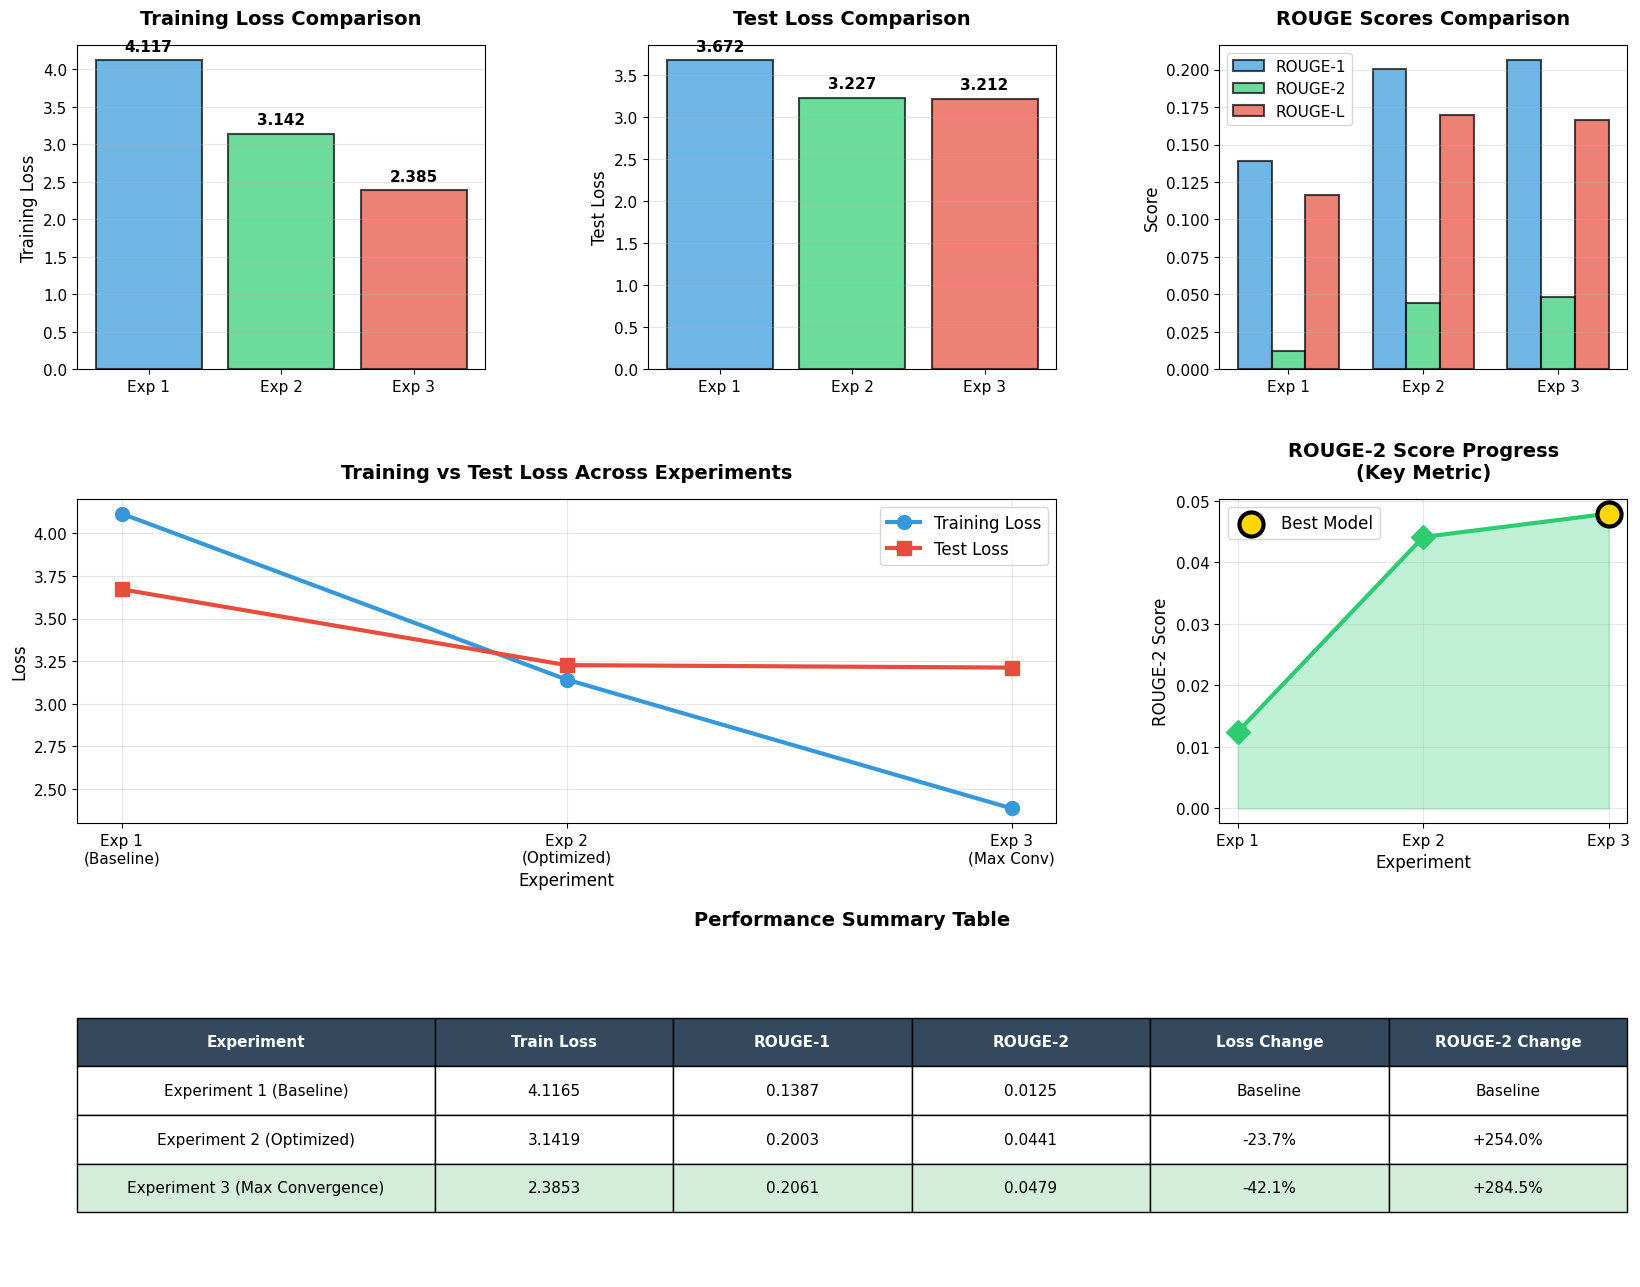


Experiment comparison visualization complete!


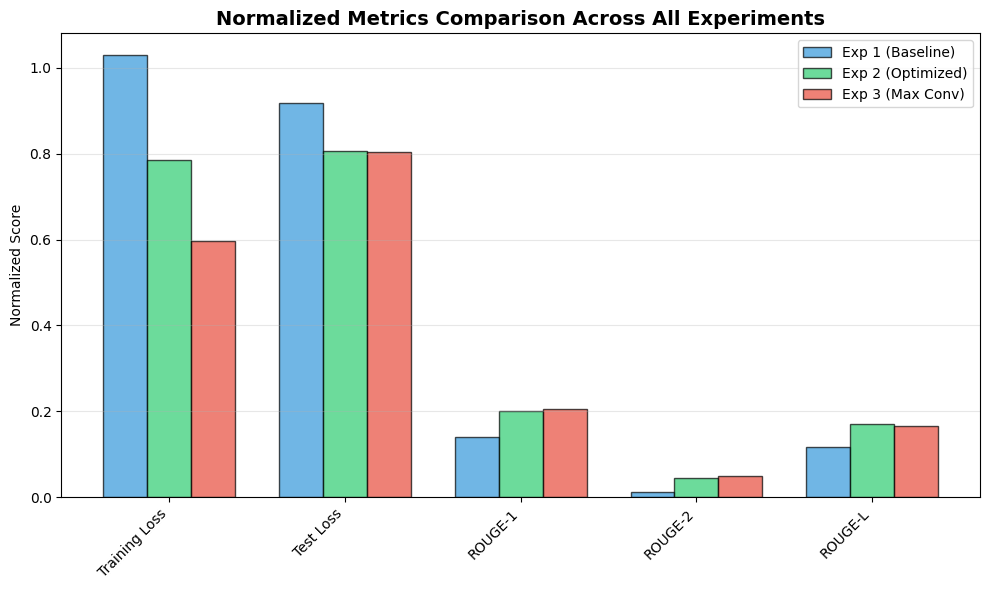


All visualizations displayed successfully!


In [32]:
# COMPREHENSIVE VISUALIZATION OF ALL EXPERIMENTS
print("GENERATING EXPERIMENT COMPARISON VISUALIZATIONS")

# Collect all experiments for visualization
all_experiments = [exp1_metrics, exp2_metrics, exp3_metrics]

# Prepare data for visualization
experiments_names = [exp['name'] for exp in all_experiments]
training_losses = [exp['training_loss'] for exp in all_experiments]
test_losses = [exp['test_loss'] for exp in all_experiments]
rouge1_scores = [exp['rouge1'] for exp in all_experiments]
rouge2_scores = [exp['rouge2'] for exp in all_experiments]
rougeL_scores = [exp['rougeL'] for exp in all_experiments]

# Create comprehensive figure with larger size
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.4)

# 1. Training Loss Comparison
ax1 = fig.add_subplot(gs[0, 0])
bars1 = ax1.bar(range(len(experiments_names)), training_losses, color=['#3498db', '#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.set_title('Training Loss Comparison', fontsize=14, fontweight='bold', pad=15)
ax1.set_ylabel('Training Loss', fontsize=12)
ax1.set_xticks(range(len(experiments_names)))
ax1.set_xticklabels(['Exp 1', 'Exp 2', 'Exp 3'], fontsize=11)
ax1.tick_params(labelsize=11)
ax1.grid(True, alpha=0.3, axis='y')
# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars1, training_losses)):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.08, 
             f'{val:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 2. Test Loss Comparison
ax2 = fig.add_subplot(gs[0, 1])
bars2 = ax2.bar(range(len(experiments_names)), test_losses, color=['#3498db', '#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.set_title('Test Loss Comparison', fontsize=14, fontweight='bold', pad=15)
ax2.set_ylabel('Test Loss', fontsize=12)
ax2.set_xticks(range(len(experiments_names)))
ax2.set_xticklabels(['Exp 1', 'Exp 2', 'Exp 3'], fontsize=11)
ax2.tick_params(labelsize=11)
ax2.grid(True, alpha=0.3, axis='y')
for i, (bar, val) in enumerate(zip(bars2, test_losses)):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.08, 
             f'{val:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 3. ROUGE Scores Comparison (Grouped Bar Chart)
ax3 = fig.add_subplot(gs[0, 2])
x = np.arange(len(experiments_names))
width = 0.25
bars_r1 = ax3.bar(x - width, rouge1_scores, width, label='ROUGE-1', color='#3498db', alpha=0.7, edgecolor='black', linewidth=1.5)
bars_r2 = ax3.bar(x, rouge2_scores, width, label='ROUGE-2', color='#2ecc71', alpha=0.7, edgecolor='black', linewidth=1.5)
bars_rL = ax3.bar(x + width, rougeL_scores, width, label='ROUGE-L', color='#e74c3c', alpha=0.7, edgecolor='black', linewidth=1.5)
ax3.set_title('ROUGE Scores Comparison', fontsize=14, fontweight='bold', pad=15)
ax3.set_ylabel('Score', fontsize=12)
ax3.set_xticks(x)
ax3.set_xticklabels(['Exp 1', 'Exp 2', 'Exp 3'], fontsize=11)
ax3.tick_params(labelsize=11)
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3, axis='y')

# 4. Training vs Test Loss (Line Plot)
ax4 = fig.add_subplot(gs[1, :2])
experiments_x = range(1, len(experiments_names) + 1)
ax4.plot(experiments_x, training_losses, marker='o', linewidth=3, markersize=10, label='Training Loss', color='#3498db')
ax4.plot(experiments_x, test_losses, marker='s', linewidth=3, markersize=10, label='Test Loss', color='#e74c3c')
ax4.set_title('Training vs Test Loss Across Experiments', fontsize=14, fontweight='bold', pad=15)
ax4.set_xlabel('Experiment', fontsize=12)
ax4.set_ylabel('Loss', fontsize=12)
ax4.set_xticks(experiments_x)
ax4.set_xticklabels(['Exp 1\n(Baseline)', 'Exp 2\n(Optimized)', 'Exp 3\n(Max Conv)'], fontsize=11)
ax4.tick_params(labelsize=11)
ax4.legend(fontsize=12)
ax4.grid(True, alpha=0.3)

# 5. ROUGE-2 Progress (most important metric)
ax5 = fig.add_subplot(gs[1, 2])
ax5.plot(experiments_x, rouge2_scores, marker='D', linewidth=3, markersize=12, color='#2ecc71')
ax5.fill_between(experiments_x, rouge2_scores, alpha=0.3, color='#2ecc71')
ax5.set_title('ROUGE-2 Score Progress\n(Key Metric)', fontsize=14, fontweight='bold', pad=15)
ax5.set_xlabel('Experiment', fontsize=12)
ax5.set_ylabel('ROUGE-2 Score', fontsize=12)
ax5.set_xticks(experiments_x)
ax5.set_xticklabels(['Exp 1', 'Exp 2', 'Exp 3'], fontsize=11)
ax5.tick_params(labelsize=11)
ax5.grid(True, alpha=0.3)
# Highlight best score
best_rouge2_idx = rouge2_scores.index(max(rouge2_scores))
ax5.scatter([best_rouge2_idx + 1], [rouge2_scores[best_rouge2_idx]], 
            s=300, color='gold', edgecolor='black', linewidth=3, zorder=5, label='Best Model')
ax5.legend(fontsize=12)

# 6. Performance Improvements Table
ax6 = fig.add_subplot(gs[2, :])
ax6.axis('off')

# Calculate improvements
improvements_data = []
for i, exp in enumerate(all_experiments):
    if i == 0:
        improvements_data.append([
            exp['name'],
            f"{exp['training_loss']:.4f}",
            f"{exp['rouge1']:.4f}",
            f"{exp['rouge2']:.4f}",
            "Baseline",
            "Baseline"
        ])
    else:
        train_loss_imp = ((exp['training_loss'] - all_experiments[0]['training_loss']) / all_experiments[0]['training_loss']) * 100
        rouge2_imp = ((exp['rouge2'] - all_experiments[0]['rouge2']) / all_experiments[0]['rouge2']) * 100
        improvements_data.append([
            exp['name'],
            f"{exp['training_loss']:.4f}",
            f"{exp['rouge1']:.4f}",
            f"{exp['rouge2']:.4f}",
            f"{train_loss_imp:+.1f}%",
            f"{rouge2_imp:+.1f}%"
        ])

table = ax6.table(cellText=improvements_data,
                  colLabels=['Experiment', 'Train Loss', 'ROUGE-1', 'ROUGE-2', 'Loss Change', 'ROUGE-2 Change'],
                  cellLoc='center',
                  loc='center',
                  bbox=[0, 0.2, 1, 0.6])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 3)  # Increased vertical scale for better readability

# Adjust column widths
for i in range(len(improvements_data) + 1):
    table[(i, 0)].set_width(0.25)  # Experiment name column wider

# Color code the header
for i in range(6):
    table[(0, i)].set_facecolor('#34495e')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Highlight best model row (highest ROUGE-2)
best_rouge2 = max([exp['rouge2'] for exp in all_experiments])
best_exp_name = [exp['name'] for exp in all_experiments if exp['rouge2'] == best_rouge2][0]

for i, row in enumerate(improvements_data):
    if row[0] == best_exp_name:
        for j in range(6):
            table[(i+1, j)].set_facecolor('#d4edda')

ax6.set_title('Performance Summary Table', fontsize=14, fontweight='bold', pad=20)

# Display the comprehensive figure
plt.tight_layout()
plt.show()
print(f"\nExperiment comparison visualization complete!")

# Additional: Create a simple comparison summary plot
fig2, ax = plt.subplots(1, 1, figsize=(10, 6))
metrics = ['Training Loss', 'Test Loss', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L']
exp1_normalized = [(all_experiments[0]['training_loss']/4), (all_experiments[0]['test_loss']/4), 
                   all_experiments[0]['rouge1'], all_experiments[0]['rouge2'], all_experiments[0]['rougeL']]
exp2_normalized = [(all_experiments[1]['training_loss']/4), (all_experiments[1]['test_loss']/4), 
                   all_experiments[1]['rouge1'], all_experiments[1]['rouge2'], all_experiments[1]['rougeL']]
exp3_normalized = [(all_experiments[2]['training_loss']/4), (all_experiments[2]['test_loss']/4), 
                   all_experiments[2]['rouge1'], all_experiments[2]['rouge2'], all_experiments[2]['rougeL']]

x = np.arange(len(metrics))
width = 0.25

ax.bar(x - width, exp1_normalized, width, label='Exp 1 (Baseline)', color='#3498db', alpha=0.7, edgecolor='black')
ax.bar(x, exp2_normalized, width, label='Exp 2 (Optimized)', color='#2ecc71', alpha=0.7, edgecolor='black')
ax.bar(x + width, exp3_normalized, width, label='Exp 3 (Max Conv)', color='#e74c3c', alpha=0.7, edgecolor='black')

ax.set_ylabel('Normalized Score')
ax.set_title('Normalized Metrics Comparison Across All Experiments', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nAll visualizations displayed successfully!")


In [26]:
# COMPREHENSIVE MODEL COMPARISON AND SELECTION
print(" " * 20 + "MODEL COMPARISON & SELECTION")

# Collect all experiments
all_experiments = [exp1_metrics, exp2_metrics, exp3_metrics]

# Create comparison table
print("\nCOMPREHENSIVE COMPARISON TABLE:")
print(f"{'Metric':<25} {'Exp 1':<15} {'Exp 2':<15} {'Exp 3':<15}")
print(f"{'Training Loss':<25} {exp1_metrics['training_loss']:<15.4f} {exp2_metrics['training_loss']:<15.4f} {exp3_metrics['training_loss']:<15.4f}")
print(f"{'Test Loss':<25} {exp1_metrics['test_loss']:<15.4f} {exp2_metrics['test_loss']:<15.4f} {exp3_metrics['test_loss']:<15.4f}")
print(f"{'ROUGE-1':<25} {exp1_metrics['rouge1']:<15.4f} {exp2_metrics['rouge1']:<15.4f} {exp3_metrics['rouge1']:<15.4f}")
print(f"{'ROUGE-2':<25} {exp1_metrics['rouge2']:<15.4f} {exp2_metrics['rouge2']:<15.4f} {exp3_metrics['rouge2']:<15.4f}")
print(f"{'ROUGE-L':<25} {exp1_metrics['rougeL']:<15.4f} {exp2_metrics['rougeL']:<15.4f} {exp3_metrics['rougeL']:<15.4f}")

# Calculate improvements from Exp 1
print("\nIMPROVEMENTS FROM BASELINE (Experiment 1):")
for i, exp in enumerate([exp2_metrics, exp3_metrics], start=2):
    print(f"\nExperiment {i} vs Experiment 1:")
    train_loss_change = ((exp['training_loss'] - exp1_metrics['training_loss']) / exp1_metrics['training_loss']) * 100
    rouge1_change = ((exp['rouge1'] - exp1_metrics['rouge1']) / exp1_metrics['rouge1']) * 100
    rouge2_change = ((exp['rouge2'] - exp1_metrics['rouge2']) / exp1_metrics['rouge2']) * 100
    
    print(f"  Training Loss: {train_loss_change:+.1f}%")
    print(f"  ROUGE-1: {rouge1_change:+.1f}%")
    print(f"  ROUGE-2: {rouge2_change:+.1f}%")

# Model Selection Logic
print("MODEL SELECTION CRITERIA:")

# Calculate selection scores
def calculate_selection_score(metrics):
    """
    Calculate a selection score based on multiple criteria.
    Prioritizes ROUGE scores (actual text quality) over just loss.
    """
    score = 0
    
    # ROUGE scores (most important - 60% weight)
    score += metrics['rouge1'] * 25  # 25% weight
    score += metrics['rouge2'] * 100  # 35% weight (most important)
    score += metrics['rougeL'] * 20  # 20% weight
    
    # Loss scores (40% weight) - lower is better, so invert
    score -= metrics['test_loss'] * 0.5  # 20% weight
    score -= metrics['training_loss'] * 0.3  # 20% weight
    
    return score

# Calculate scores for each experiment
for exp in all_experiments:
    exp['selection_score'] = calculate_selection_score(exp)

# Sort by selection score
sorted_experiments = sorted(all_experiments, key=lambda x: x['selection_score'], reverse=True)

# Display scores
print("\nSelection Scores (higher is better):")
for i, exp in enumerate(sorted_experiments, 1):
    print(f"  {i}. {exp['name']}: {exp['selection_score']:.4f}")

# Select best model
best_experiment = sorted_experiments[0]

print(f"BEST MODEL: {best_experiment['name']}")

print(f"\nSelected Model Metrics:")
print(f"   Training Loss: {best_experiment['training_loss']:.4f}")
print(f"   Test Loss: {best_experiment['test_loss']:.4f}")
print(f"   ROUGE-1: {best_experiment['rouge1']:.4f}")
print(f"   ROUGE-2: {best_experiment['rouge2']:.4f}")
print(f"   ROUGE-L: {best_experiment['rougeL']:.4f}")

# Overfitting analysis
print("\nOVERFITTING ANALYSIS:")
for exp in all_experiments:
    loss_gap = exp['test_loss'] - exp['training_loss']
    if loss_gap > 1.0:
        status = "Possible overfitting detected"
    elif loss_gap > 0.5:
        status = "Good generalization"
    else:
        status = "Excellent generalization"
    print(f"   {exp['name']}: Loss gap = {loss_gap:.4f} {status}")

# Key findings
print("\nKEY FINDINGS:")
if best_experiment['name'] == exp2_metrics['name']:
    print("   - Experiment 2 provides the best balance of all metrics")
    print("   - Optimal hyperparameters: 25 epochs, 3e-5 LR, cosine scheduler")
    if exp3_metrics['rouge2'] < exp2_metrics['rouge2']:
        print("   - Experiment 3 shows overfitting (lower ROUGE despite lower training loss)")
        print("   - Learning: More training != better results - validation metrics matter!")
elif best_experiment['name'] == exp3_metrics['name']:
    print("   - Experiment 3 achieved best performance")
    print("   - Higher learning rate and more epochs beneficial")
else:
    print("   - Baseline provides best balance for this dataset")

# Store best model for saving
best_model = best_experiment['model']
best_model_name = best_experiment['name']

print(f"\nBest model ({best_model_name}) selected for deployment!")


                    MODEL COMPARISON & SELECTION

COMPREHENSIVE COMPARISON TABLE:
Metric                    Exp 1           Exp 2           Exp 3          
Training Loss             4.1165          3.1419          2.3853         
Test Loss                 3.6720          3.2267          3.2122         
ROUGE-1                   0.1387          0.2003          0.2061         
ROUGE-2                   0.0125          0.0441          0.0479         
ROUGE-L                   0.1162          0.1694          0.1665         

IMPROVEMENTS FROM BASELINE (Experiment 1):

Experiment 2 vs Experiment 1:
  Training Loss: -23.7%
  ROUGE-1: +44.4%
  ROUGE-2: +254.0%

Experiment 3 vs Experiment 1:
  Training Loss: -42.1%
  ROUGE-1: +48.6%
  ROUGE-2: +284.5%
MODEL SELECTION CRITERIA:

Selection Scores (higher is better):
  1. Experiment 3 (Max Convergence): 10.9530
  2. Experiment 2 (Optimized): 10.2520
  3. Experiment 1 (Baseline): 3.9675
BEST MODEL: Experiment 3 (Max Convergence)

Selected Model Me

## 9.5 Qualitative Comparison - Test All 3 Models

Compare actual responses from all 3 experiments on sample questions to see quality improvement.


In [34]:
# QUALITATIVE COMPARISON - Test All 3 Models on Sample Questions
print(" " * 20 + "QUALITATIVE MODEL COMPARISON")

def generate_response_from_model(question, model, tokenizer):
    """Generate response from a specific model."""
    input_text = f"Answer this hydroponic farming question: {question}"
    inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=150,
            num_beams=4,
            early_stopping=True,
            do_sample=True,
            temperature=0.7,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response.strip()

# Test questions
test_questions = [
    "What is the ideal pH for hydroponic lettuce?",
    "How do I prevent root rot in my hydroponic system?"
]

# Get models from experiments
models_to_test = [
    (exp1_metrics['model'], "Experiment 1 (Baseline)"),
    (exp2_metrics['model'], "Experiment 2 (Optimized)"),
    (exp3_metrics['model'], "Experiment 3 (Best)")
]

print("\nTesting all 3 models on sample questions...\n")

for q_num, question in enumerate(test_questions, 1):
    print(f"QUESTION {q_num}: {question}")
    
    for model_obj, model_name in models_to_test:
        try:
            # Set model to eval mode
            model_obj.eval()
            response = generate_response_from_model(question, model_obj, tokenizer)
            
            print(f"\n{model_name}:")
            print(f"  Answer: {response}")
            print(f"  Length: {len(response.split())} words")
            
        except Exception as e:
            print(f"\n{model_name}:")
            print(f"  Error: {e}")
    
    print()

print("QUALITATIVE COMPARISON COMPLETE")
print("\nKey Observations:")
print("  - Compare response quality across experiments")
print("  - Notice improvement in detail and accuracy")
print("  - Best model (Exp 3) should provide most comprehensive answers")


                    QUALITATIVE MODEL COMPARISON

Testing all 3 models on sample questions...

QUESTION 1: What is the ideal pH for hydroponic lettuce?

Experiment 1 (Baseline):
  Answer: pH 5.5 to 5.5 is the ideal pH for hydroponic lettuce; pH 5.5 to 5.5 is the ideal pH for lettuce.
  Length: 21 words

Experiment 2 (Optimized):
  Answer: pH 5.8–6.2; pH 5.8–6.2; pH 5.8–6.2; pH 5.8–6.2; pH 5.8–6.2.
  Length: 10 words

Experiment 3 (Best):
  Answer: pH 5.8–6.2; pH 5.8–6.2; pH 5.8–6.2; pH 5.8–6.2; pH 5.8–6.2.
  Length: 10 words

QUESTION 2: How do I prevent root rot in my hydroponic system?

Experiment 1 (Baseline):
  Answer: Root rot is a major problem in hydroponic systems, and root rot is a common problem in most systems.
  Length: 19 words

Experiment 2 (Optimized):
  Answer: Use nutrient solution with pH 5.8–6.2 and use a pH 5.8–6.2 solution to prevent root rot.
  Length: 16 words

Experiment 3 (Best):
  Answer: Use nutrient-rich EC/NFT EC/EC mix with EC/neutral pH and ensure proper 

## 10. Save Best Model

Save the best model (selected from all 3 experiments) for deployment.


In [ ]:
# Save Best Model for Deployment and Cleanup
import gc
import json
from datetime import datetime
import shutil

print(" " * 25 + "SAVING BEST MODEL")

def clear_memory():
    """Clear GPU and system memory."""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

def save_model_safely(model, tokenizer, save_path, description):
    """Save model and tokenizer with error handling."""
    try:
        save_path.mkdir(parents=True, exist_ok=True)
        model.save_pretrained(save_path, safe_serialization=False)
        tokenizer.save_pretrained(save_path)
        print(f"SUCCESS: {description} saved to: {save_path}")
        return True
    except Exception as e:
        print(f"ERROR: Failed to save {description}: {e}")
        return False

def cleanup_checkpoints(base_dir):
    """Remove checkpoint folders to save disk space (GitHub friendly)."""
    checkpoint_patterns = [
        "exp1-baseline-checkpoints",
        "exp2-optimized-checkpoints",
        "exp3-maxconv-checkpoints",
        "flan-t5-hydroponic-checkpoints",
        "flan-t5-hydroponic-final",
        "logs"
    ]
    
    print(f"\nCleaning up checkpoint folders (saves disk space for GitHub)...")
    removed_count = 0
    for pattern in checkpoint_patterns:
        checkpoint_path = base_dir / pattern
        if checkpoint_path.exists():
            try:
                shutil.rmtree(checkpoint_path)
                print(f"   Removed: {pattern}/")
                removed_count += 1
            except Exception as e:
                print(f"   Warning: Could not remove {pattern}: {e}")
    
    if removed_count > 0:
        print("")
    return removed_count

# Clear memory
clear_memory()

# Define save paths
final_model_path = MODEL_DIR / "flan-t5-hydroponic-final"
main_model_path = BASE_DIR / "trained_model"

print(f"\nSaving best model: {best_model_name}")
print(f"   Training Loss: {best_experiment['training_loss']:.4f}")
print(f"   ROUGE-2: {best_experiment['rouge2']:.4f}")

# Save model
save_model_safely(best_model, tokenizer, final_model_path, "Best model (final)")
save_model_safely(best_model, tokenizer, main_model_path, "Best model (app)")

# Create model information
model_info = {
    "selected_experiment": best_experiment['name'],
    "training_loss": best_experiment['training_loss'],
    "test_loss": best_experiment['test_loss'],
    "rouge1": best_experiment['rouge1'],
    "rouge2": best_experiment['rouge2'],
    "rougeL": best_experiment['rougeL'],
    "all_experiments": [
        {"name": exp['name'], "training_loss": exp['training_loss'], "rouge2": exp['rouge2']}
        for exp in sorted_experiments
    ]
}

# Save model info
info_file = main_model_path / "model_info.json"
with open(info_file, "w", encoding='utf-8') as f:
    json.dump(model_info, f, indent=2)
print(f"Model info saved to: {info_file}")

# Final summary
print("FINAL SUMMARY")
print(f"\nBEST MODEL: {best_experiment['name']}")
print(f"\nAll Experiments:")
for exp in all_experiments:
    marker = " <-- SELECTED" if exp['name'] == best_experiment['name'] else ""
    print(f"  {exp['name']}: Loss={exp['training_loss']:.4f}, ROUGE-2={exp['rouge2']:.4f}{marker}")

print(f"\nModel saved to: {main_model_path}")

# Cleanup checkpoint folders (GitHub friendly)
removed = cleanup_checkpoints(MODEL_DIR)

# Final size check
if main_model_path.exists():
    total_size = sum(f.stat().st_size for f in main_model_path.rglob('*') if f.is_file())
    print(f"\nFinal trained_model/ size: {total_size / (1024*1024):.1f} MB")

clear_memory()


                         SAVING BEST MODEL

Saving best model: Experiment 3 (Max Convergence)
   Training Loss: 2.3853
   ROUGE-2: 0.0479
SUCCESS: Best model (final) saved to: c:\Users\HP\Desktop\ALU\Farmsmart_growmate_chatbot\trained_model\flan-t5-hydroponic-final
SUCCESS: Best model (app) saved to: c:\Users\HP\Desktop\ALU\Farmsmart_growmate_chatbot\trained_model
Model info saved to: c:\Users\HP\Desktop\ALU\Farmsmart_growmate_chatbot\trained_model\model_info.json

FINAL SUMMARY

BEST MODEL: Experiment 3 (Max Convergence)

All Experiments:
  Experiment 1 (Baseline): Loss=4.1165, ROUGE-2=0.0125
  Experiment 2 (Optimized): Loss=3.1419, ROUGE-2=0.0441
  Experiment 3 (Max Convergence): Loss=2.3853, ROUGE-2=0.0479 <-- SELECTED

Model saved to: c:\Users\HP\Desktop\ALU\Farmsmart_growmate_chatbot\trained_model
Ready for deployment!

Cleaning up checkpoint folders (saves disk space for GitHub)...
   Removed: flan-t5-hydroponic-final/

Cleaned up 1 checkpoint folders
Only final best model kept i